
Randomly selected: 20211222_125057_petiole4_00012.tiff
Geometry file: 20211222_125057_petiole4_00012_object_geometry_cleaned.txt
Class mapping file: 20211222_125057_petiole4_00012_object_class_mapping_cleaned.txt

Loading and normalizing image...
Saving class-level mask...
Saving object-level mask...
Saving class-level overlay...
Saving object-level overlay...
Saving normalized image as PNG...

Image size: (2560, 2560)
Number of objects: 2083
Unique categories in mask: [1 2 3 4 5]
Unique objects in mask: 2083 objects

Saved files to ./data/verification:
  - 20211222_125057_petiole4_00012_original_image.png (normalized original image)
  - 20211222_125057_petiole4_00012_class_mask_colored.png (class-level mask)
  - 20211222_125057_petiole4_00012_object_mask_colored.png (object-level mask)
  - 20211222_125057_petiole4_00012_class_overlay.png (class mask overlaid on normalized original)
  - 20211222_125057_petiole4_00012_object_overlay.png (object mask overlaid on normalized original)


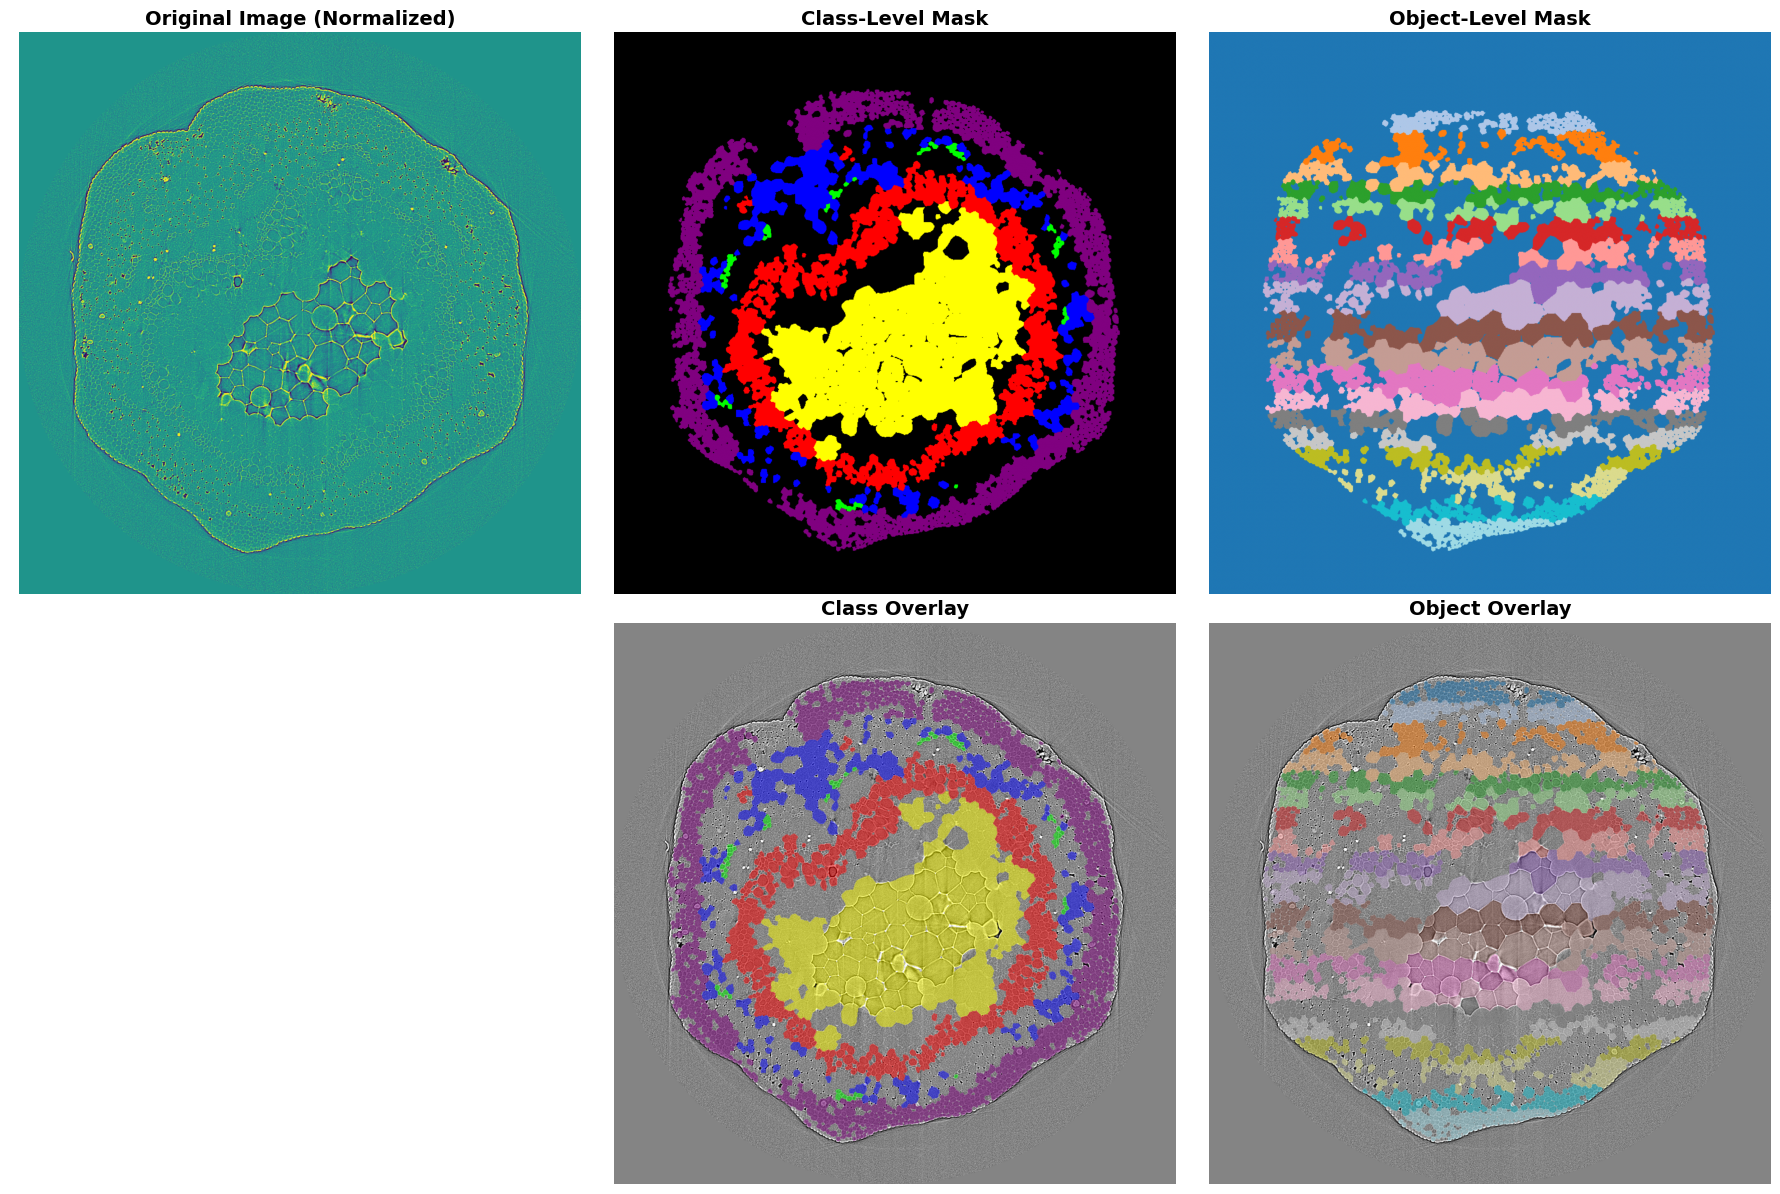

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import random

def read_geometry_file(file_path):
    """Read polygon coordinates from object_geometry.txt."""
    geometries = {}
    with open(file_path, 'r') as f:
        # Skip header line
        next(f)
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                obj_id = int(parts[0])
                
                # Parse polygon coordinates
                polygon_str = parts[1]
                coords = []
                for point in polygon_str.split(';'):
                    x, y = map(int, point.split(','))
                    coords.append((x, y))
                
                # Parse bounding box
                bbox_str = parts[2]
                bbox = list(map(int, bbox_str.split(',')))
                
                geometries[obj_id] = {
                    'coords': coords,
                    'bbox': bbox
                }
    
    return geometries

def read_class_mapping(file_path):
    """Read class mapping from object_class_mapping.txt."""
    class_mapping = {}
    with open(file_path, 'r') as f:
        # Skip header line
        next(f)
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                obj_id = int(parts[0])
                class_id = int(parts[1])
                class_mapping[obj_id] = class_id
    
    return class_mapping

def normalize_image(img):
    """Normalize TIFF image for display."""
    img_np = np.array(img)
    
    # Normalize image for display
    if img.mode not in ['RGB', 'L', 'RGBA']:
        if img.mode in ['I', 'I;16', 'F']:
            img_array = img_np.copy().astype(np.float32)
            p_low = np.percentile(img_array, 0.5)
            p_high = np.percentile(img_array, 99.5)
            img_array = np.clip(img_array, p_low, p_high)
            img_array = ((img_array - p_low) / (p_high - p_low) * 255).astype(np.uint8)
            img_disp = Image.fromarray(img_array)
        else:
            img_disp = img.convert('L')
    else:
        img_array = img_np.copy().astype(np.float32)
        p_low = np.percentile(img_array, 0.5)
        p_high = np.percentile(img_array, 99.5)
        img_array = np.clip(img_array, p_low, p_high)
        img_disp = Image.fromarray(((img_array - p_low) / (p_high - p_low) * 255).astype(np.uint8))
    
    return img_disp

def create_masks(image_path, geometry_path, class_path):
    """Create class-level and object-level masks from separate files."""
    # Load image to get dimensions
    img = Image.open(image_path)
    width, height = img.size
    
    # Normalize image for display
    img_normalized = normalize_image(img)
    
    # Read geometry and class mapping
    geometries = read_geometry_file(geometry_path)
    class_mapping = read_class_mapping(class_path)
    
    # Initialize masks
    class_mask = np.zeros((height, width), dtype=np.uint8)
    object_mask = np.zeros((height, width), dtype=np.uint16)
    
    # Draw each object
    for obj_id in geometries.keys():
        coords = geometries[obj_id]['coords']
        category_id = class_mapping.get(obj_id, 0)
        
        # Create temporary image for this polygon
        temp_class = Image.new('L', (width, height), 0)
        temp_object = Image.new('I', (width, height), 0)
        
        draw_class = ImageDraw.Draw(temp_class)
        draw_object = ImageDraw.Draw(temp_object)
        
        # Draw filled polygon
        draw_class.polygon(coords, fill=category_id)
        draw_object.polygon(coords, fill=obj_id)
        
        # Convert to numpy and update masks
        temp_class_np = np.array(temp_class)
        temp_object_np = np.array(temp_object)
        
        # Update masks
        class_mask = np.where(temp_class_np > 0, temp_class_np, class_mask)
        object_mask = np.where(temp_object_np > 0, temp_object_np, object_mask)
    
    return img_normalized, class_mask, object_mask, geometries, class_mapping

def save_mask_as_png(mask, output_path, colormap, vmin=0, vmax=None):
    """Save a mask as PNG with specified colormap at original resolution."""
    if vmax is None:
        vmax = mask.max()
    
    # Normalize mask to 0-1 range
    mask_normalized = (mask - vmin) / (vmax - vmin)
    mask_normalized = np.clip(mask_normalized, 0, 1)
    
    # Apply colormap
    colored_mask = colormap(mask_normalized)
    
    # Convert to 8-bit RGB (remove alpha channel)
    colored_mask_rgb = (colored_mask[:, :, :3] * 255).astype(np.uint8)
    
    # Save as PNG
    Image.fromarray(colored_mask_rgb).save(output_path)

def save_overlay_as_png(original_img, mask, output_path, colormap, vmin=0, vmax=None, alpha=0.5):
    """Save an overlay of mask on original image as PNG."""
    if vmax is None:
        vmax = mask.max()
    
    # Convert original image to RGB if needed
    if original_img.mode != 'RGB':
        original_img = original_img.convert('RGB')
    
    original_array = np.array(original_img)
    
    # Normalize mask to 0-1 range
    mask_normalized = (mask - vmin) / (vmax - vmin)
    mask_normalized = np.clip(mask_normalized, 0, 1)
    
    # Apply colormap
    colored_mask = colormap(mask_normalized)
    colored_mask_rgb = (colored_mask[:, :, :3] * 255).astype(np.uint8)
    
    # Create overlay where mask > 0
    overlay = original_array.copy()
    mask_presence = mask > 0
    overlay[mask_presence] = (
        alpha * colored_mask_rgb[mask_presence] + 
        (1 - alpha) * original_array[mask_presence]
    ).astype(np.uint8)
    
    # Save as PNG
    Image.fromarray(overlay).save(output_path)

def find_random_image_with_meta():
    """
    Randomly select an image from ./data/images and find corresponding cleaned txt files.
    
    Returns:
        tuple: (image_path, geometry_path, class_path) or (None, None, None) if no valid files
    """
    images_dir = Path("./data/images")
    meta_dir = Path("./data/meta")
    
    # Get all image files
    image_files = list(images_dir.glob("*.tiff")) + list(images_dir.glob("*.tif"))
    
    if not image_files:
        print("No image files found in ./data/images")
        return None, None, None
    
    # Shuffle and try to find valid file with cleaned metadata
    random.shuffle(image_files)
    
    for image_path in image_files:
        base_name = image_path.stem
        
        # Look for cleaned txt files
        geometry_path = meta_dir / f"{base_name}_object_geometry_cleaned.txt"
        class_path = meta_dir / f"{base_name}_object_class_mapping_cleaned.txt"
        
        if geometry_path.exists() and class_path.exists():
            print(f"\nRandomly selected: {image_path.name}")
            print(f"Geometry file: {geometry_path.name}")
            print(f"Class mapping file: {class_path.name}")
            return image_path, geometry_path, class_path
    
    print("No image files found with corresponding cleaned metadata files")
    return None, None, None


# Create verification output directory
verification_dir = Path("./data/verification")
verification_dir.mkdir(parents=True, exist_ok=True)

# Randomly select an image and find corresponding files
image_path, geometry_path, class_path = find_random_image_with_meta()

if image_path is None:
    print("\nError: Could not find a valid image with cleaned metadata files.")
    print("Please ensure:")
    print("  1. Images exist in ./data/images")
    print("  2. Cleaned txt files exist in ./data/meta")
else:
    base_name = image_path.stem
    
    # Load and process
    print("\nLoading and normalizing image...")
    img_normalized, class_mask, object_mask, geometries, class_mapping = create_masks(
        image_path,
        geometry_path,
        class_path
    )
    
    # Define custom colormap for classes
    class_colors = [
        [0, 0, 0],      # 0: Background (black)
        [0, 0, 255],    # 1: Cortex (blue)
        [0, 255, 0],    # 2: Phloem Fibers (green)
        [255, 0, 0],    # 3: Xylem vessels (red)
        [255, 255, 0],  # 4: Pith cells (yellow)
        [128, 0, 128]   # 5: Epidermis (purple)
    ]
    
    # Create colormaps
    class_colors_norm = np.array(class_colors) / 255.0
    class_cmap = ListedColormap(class_colors_norm)
    object_cmap = plt.cm.tab20
    
    # Save class-level mask as PNG
    print("Saving class-level mask...")
    output_path = verification_dir / f"{base_name}_class_mask_colored.png"
    save_mask_as_png(class_mask, output_path, class_cmap, vmin=0, vmax=5)
    
    # Save object-level mask as PNG
    print("Saving object-level mask...")
    output_path = verification_dir / f"{base_name}_object_mask_colored.png"
    save_mask_as_png(object_mask, output_path, object_cmap, vmin=0, vmax=object_mask.max())
    
    # Save class-level overlay as PNG
    print("Saving class-level overlay...")
    output_path = verification_dir / f"{base_name}_class_overlay.png"
    save_overlay_as_png(img_normalized, class_mask, output_path, class_cmap, vmin=0, vmax=5, alpha=0.5)
    
    # Save object-level overlay as PNG
    print("Saving object-level overlay...")
    output_path = verification_dir / f"{base_name}_object_overlay.png"
    save_overlay_as_png(img_normalized, object_mask, output_path, object_cmap, vmin=0, vmax=object_mask.max(), alpha=0.5)
    
    # Also save the normalized image as PNG for reference
    print("Saving normalized image as PNG...")
    output_path = verification_dir / f"{base_name}_original_image.png"
    img_normalized.save(output_path)
    
    # Print statistics
    print(f"\nImage size: {img_normalized.size}")
    print(f"Number of objects: {len(geometries)}")
    print(f"Unique categories in mask: {np.unique(class_mask[class_mask > 0])}")
    print(f"Unique objects in mask: {len(np.unique(object_mask[object_mask > 0]))} objects")
    
    print("\nSaved files to ./data/verification:")
    print(f"  - {base_name}_original_image.png (normalized original image)")
    print(f"  - {base_name}_class_mask_colored.png (class-level mask)")
    print(f"  - {base_name}_object_mask_colored.png (object-level mask)")
    print(f"  - {base_name}_class_overlay.png (class mask overlaid on normalized original)")
    print(f"  - {base_name}_object_overlay.png (object mask overlaid on normalized original)")
    
    # Optional: Display the results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0, 0].imshow(img_normalized)
    axes[0, 0].set_title('Original Image (Normalized)', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(class_mask, cmap=class_cmap, vmin=0, vmax=5)
    axes[0, 1].set_title('Class-Level Mask', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(object_mask, cmap=object_cmap)
    axes[0, 2].set_title('Object-Level Mask', fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Load and display saved overlay images
    class_overlay = Image.open(verification_dir / f"{base_name}_class_overlay.png")
    object_overlay = Image.open(verification_dir / f"{base_name}_object_overlay.png")
    
    axes[1, 0].axis('off')  # Empty cell
    
    axes[1, 1].imshow(class_overlay)
    axes[1, 1].set_title('Class Overlay', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(object_overlay)
    axes[1, 2].set_title('Object Overlay', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()